## Import datas

In [154]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [155]:
# Use pandas to loadinto a DataFrame
# Y1.csv doesn’t have a header so
# add one when loading the file
X1 = pd.read_csv("data/X1.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])


# ENLEVER colonne "Unnamed" du dataset : utilité ? -> Pas listé dans les features du pdf
X = X1.drop(['Unnamed: 0', 'img_url', 'description'], axis=1)

X.head()
X.describe()
#sns.pairplot(X)


,ratings,n_votes,is_adult,production_year,release_year
count,4012.000000,4.012000e+03,4012.0,4012.000000,4012.000000
mean,6.530409,2.260019e+04,0.0,1997.395563,2000.056082
std,1.208409,9.956869e+04,0.0,12.066252,10.245970
min,1.900000,5.000000e+00,0.0,1916.000000,1921.000000
25%,5.800000,8.275000e+01,0.0,1992.000000,1994.000000
50%,6.600000,9.000000e+02,0.0,2001.000000,2002.000000
75%,7.300000,7.195750e+03,0.0,2006.000000,2007.000000
max,10.000000,2.369294e+06,0.0,2021.000000,2018.000000


## Preprocessing the data

In [156]:
"""
Creating empty DataFrame to start
"""
n_samples = X.shape[0]
data = pd.DataFrame()

In [157]:
"""
Keeping the directly usable features
"""

directly_usable_features = ["ratings", "n_votes", "is_adult"]
for feature in directly_usable_features:
    data[feature] = X[feature]

In [158]:
"""
Dealing with the "production_year" feature
"""

n_year_period = 5 # n_year_period categorical features for each computed period
style = "per_quantile"
# style = "per_period_length"
# style = "no_period"


# Removing previously computed categorie(s) for the "production_year" initial feature

for feature in data.columns:
    if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "production_year" initial feature

prod_year = X["production_year"].copy()
if style == "per_quantile" or style == "per_period_length":
    categories = np.ones((n_year_period, n_samples))
    
    if style == "per_quantile":
        thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
    else :
        thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
    for i, threshold in enumerate(thresholds):
        categories[i+1] = (prod_year >= threshold).astype(int)
        categories[i] -= categories[i+1]
    for period in range(n_year_period):
        data["period {}".format(period)] = categories[period]
elif style == "no_period":
    data["production_year"] = prod_year

In [159]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

# Add other smarter ways ?

# replace_type = "zero"
replace_type = "mean"

runtime = X["runtime"].copy()
if replace_type == "zero":
    runtime[runtime == "\\N"] = 0
if replace_type == "mean":
    mean = np.mean(runtime[runtime != "\\N"].astype(float))
    runtime[runtime == "\\N"] = mean
data["runtime"] = runtime.astype(float)    

In [160]:
"""
Dealing with the "studio" feature


Juste rajouter toute les features une par une me semblait un peu lourd (yen a 509), ducoup j'effectue PCA dessus.
Jsp si ça se fait ? (on peut changer l'algo de dimensionality reduction aussi si on veut)
"""

use_PCA = True
dim = 20 # output dimension of vectors created by PCA if PCA is used


# Removing previously computed categorie(s) for the "studio" initial feature
for feature in data.columns:
    if len(feature) >= 10 and feature[:10] == "studio_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "studio" initial feature
studio = X["studio"].copy()
studio_labels = np.unique(studio)
studio_features = np.zeros((len(studio_labels), n_samples))
for i, label in enumerate(studio_labels) :
    studio_features[i] = (studio == label).astype(int)

# Applying pca or not
if use_PCA :
    pca = PCA(n_components=dim)
    out = pca.fit_transform(studio_features.T)
else :
    out = studio_features.T
    
data[["studio_PC_{}".format(i) for i in range(dim)]] = out

# Ya plein de warnings quand dim trop grand ou pas de PCA /: 
# jsp comment regler ça... en utilisant pd.concat ça tourne vraiment extrêmement lentement

In [161]:
"""
Dealing with the "genres" feature

Je rajoute juste une feature par genre, j'espère ça suffit ? -> pt-être dimension reduction sur ça aussi ?
Certains films ont pas de genre attitré (genre = "\\N"),
ce que j'ai fait ici considère ça comme un genre à part entière, ptet on peut deal le truc autrement ?
"""

all_genres = X["genres"].copy()
diff_genres = []
for genres in np.unique(all_genres):
    for genre in genres.split(",") :
        if not genre in diff_genres :
            diff_genres.append(genre)
            
for genre in diff_genres:
    data[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]

In [162]:
"""
Dealing with the "text_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""

output_dim = 20 # output dimension of PCA


# Removing previously computed categorie(s) for the "text_embedding" initial feature
for feature in data.columns:
    if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "text_embedding" initial feature
text_embeddings = X["text_embeddings"]
input_dim = 768
embeddings = np.zeros((n_samples, input_dim))
for i, text_embedding in enumerate(text_embeddings):
    embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))

# applying PCA
pca = PCA(n_components=output_dim)
output = pca.fit_transform(embeddings)

data[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

In [163]:
"""
Dealing with the "img_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""

output_dim = 20 # output dimension of PCA


# Removing previously computed categorie(s) for the "img_embedding" initial feature
for feature in data.columns:
    if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "img_embedding" initial feature
img_embeddings = X["img_embeddings"]
input_dim = 2048
embeddings = np.zeros((n_samples, input_dim))
for i, img_embedding in enumerate(img_embeddings):
    embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

# applying PCA
pca = PCA(n_components=output_dim)
output = pca.fit_transform(embeddings)

data[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

In [164]:
data.head()

,ratings,n_votes,is_adult,period 0,period 1,period 2,period 3,period 4,runtime,studio_PC_0,...,img_embedding_PC_10,img_embedding_PC_11,img_embedding_PC_12,img_embedding_PC_13,img_embedding_PC_14,img_embedding_PC_15,img_embedding_PC_16,img_embedding_PC_17,img_embedding_PC_18,img_embedding_PC_19
0,6.2,33519.0,0,0.0,1.0,0.0,0.0,0.0,104.000000,0.942714,...,0.580424,0.387142,0.302313,0.052249,0.527234,0.702357,-1.757796,3.290063,-2.737451,-0.053648
1,7.7,647.0,0,0.0,0.0,0.0,1.0,0.0,118.000000,-0.036620,...,3.265436,-0.572711,1.783883,-2.966089,1.724237,1.440683,0.593585,-2.613198,2.977780,-0.114235
2,5.8,43497.0,0,0.0,0.0,0.0,0.0,1.0,119.000000,-0.186940,...,-0.675745,-1.220855,1.217127,-1.127158,-2.920884,-0.220816,-2.468477,1.411635,-1.477865,-0.522745
3,7.7,16.0,0,1.0,0.0,0.0,0.0,0.0,30.000000,-0.035555,...,0.663574,-4.217158,-0.706687,0.740666,-1.968355,-0.730368,-0.747786,-0.025271,1.047613,0.393862
4,5.7,7.0,0,0.0,0.0,0.0,1.0,0.0,88.304408,-0.034550,...,-4.110027,1.038624,-0.498139,-3.851319,-1.025219,0.316227,1.425161,1.233834,-0.645961,-2.251220


### Compute the Root Mean Square Error

In [165]:
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

In [166]:
# Creer un data training/validation splités a partir du X1 (on garde X2 pour les vrais tests) 
X_train, X_test, y_train, y_test = train_test_split(data, Y1, test_size = 0.2, random_state=1)

### Linear Regression

In [167]:
def fit_predict_with_features(X_train,Y_train, X_test, Y_test, selected_features):
    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]
    
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train_filtered,Y_train)
    print(clf.score(X_test_filtered, Y_test))
    y_pred = clf.predict(X_test_filtered)

    return y_pred

In [168]:
print('By selecting features')
# Dans ce cas, on selectionne tout
Y_pred = fit_predict_with_features(X_train,y_train, X_test, y_test, X_train.columns)


By selecting features
0.30449304372352515


### GridSearch on KNN

In [169]:
def perform_grid_search(model_, params, scoring,X_train, y_train):

    clf = GridSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid_result = clf.fit(X_train,y_train)
    print("clf.best_score_: ", clf.best_score_)
    print("clf.best_params_: ",clf.best_params_)
    return grid_result
 
    
params =    {'n_neighbors' : range(3, 40), 
            'weights' : ['uniform', 'distance']}
knn = KNeighborsRegressor(n_jobs=-1)
scoring = "neg_mean_squared_error"

grid = perform_grid_search(knn, params, scoring, X_train, y_train)
pred = grid.best_estimator_.predict(X_test)
print("pred: ",pred)

print("Score")
model = grid.best_estimator_
print(model.score(X_test,y_test))
rmse = compute_rmse(pred, y_test)
rmse

clf.best_score_:  -5254621968637311.0
clf.best_params_:  {'n_neighbors': 39, 'weights': 'uniform'}
pred:  [[2.54051152e+07]
 [2.60081965e+07]
 [3.86058646e+07]
 [7.74057360e+06]
 [2.47288353e+07]
 [2.05544975e+07]
 [1.28876323e+07]
 [1.06185311e+08]
 [7.95745853e+06]
 [5.35471015e+07]
 [2.52348957e+06]
 [8.90273484e+06]
 [3.71675059e+07]
 [1.23439071e+06]
 [5.55322867e+07]
 [2.52805482e+07]
 [3.33346753e+07]
 [2.34476309e+07]
 [6.26706722e+06]
 [4.63370971e+07]
 [1.93608061e+07]
 [1.50564222e+07]
 [1.23502963e+07]
 [8.93040241e+06]
 [1.19799277e+07]
 [1.82520152e+08]
 [2.02701679e+07]
 [3.91599912e+07]
 [1.86652226e+07]
 [3.08175016e+07]
 [5.87878431e+05]
 [4.62758812e+07]
 [2.93330162e+07]
 [2.37821790e+07]
 [9.19178381e+07]
 [2.22172400e+07]
 [3.40174517e+06]
 [7.11978749e+06]
 [2.68341329e+07]
 [4.56711668e+06]
 [2.03261043e+07]
 [3.40825807e+07]
 [6.27266833e+06]
 [4.37776371e+06]
 [4.26298305e+06]
 [2.40436674e+07]
 [1.19651843e+08]
 [5.51814855e+07]
 [9.00073619e+06]
 [2.89247475

94480335.80282257

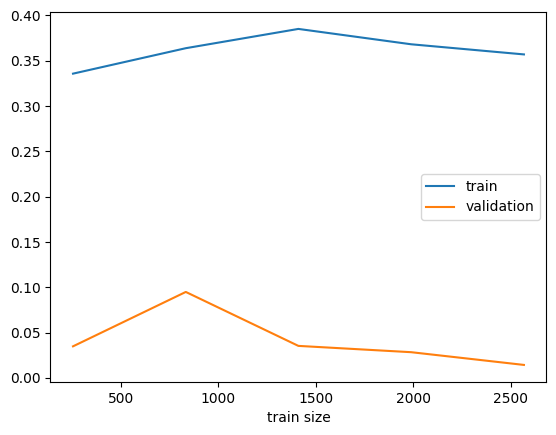

In [170]:
N, train_score, val_score = learning_curve(knn, X_train, y_train, cv=5)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("train size")
plt.legend()

In [151]:
# see the report of grid search
res = pd.DataFrame(grid.cv_results_.values(), ).transpose()
res.columns=grid.cv_results_.keys()
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055274,0.015644,0.646017,0.033278,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",-5671317404471970.0,-6970245596036319.0,-6217602232902106.0,-8532832037471765.0,-6676531392695904.0,-6813705732715612.0,965308992506551.5,73
1,0.037925,0.005317,0.661861,0.035324,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",-5617047739395090.0,-6687749877611995.0,-6313917690803708.0,-9327807908255248.0,-6589123971989950.0,-6907129437611198.0,1266897793065612.5,74
2,0.031826,0.008181,0.265704,0.259521,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",-5095712065905189.0,-6334065676483899.0,-5886364163710549.0,-8240403536277951.0,-6278244340599413.0,-6366957956595400.0,1035933092061673.75,71
3,0.021943,0.001409,0.052058,0.002634,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",-5173607418766995.0,-6173920096069931.0,-5925888212660418.0,-8886384277767806.0,-6237717795085497.0,-6479503560070130.0,1261488888861288.25,72
4,0.032312,0.010513,0.06343,0.014721,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",-4960889194467808.0,-5952051300009233.0,-5705005972710784.0,-7835626315161203.0,-6217332516274635.0,-6134181059724733.0,948241153688150.75,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.068734,0.028801,0.113025,0.040378,37,distance,"{'n_neighbors': 37, 'weights': 'distance'}",-4365760906820314.5,-4787182363214539.0,-4846327557147800.0,-7581148683598239.0,-5430164149943729.0,-5402116732144924.0,1141056193613589.75,26
70,0.077007,0.062414,0.179484,0.124016,38,uniform,"{'n_neighbors': 38, 'weights': 'uniform'}",-4172063112626370.5,-4879332819595731.0,-4573767820705397.0,-7113245510097684.0,-5543731226136641.0,-5256428097832365.0,1030959486498022.25,2
71,0.030319,0.010601,0.099343,0.017103,38,distance,"{'n_neighbors': 38, 'weights': 'distance'}",-4362249103084402.0,-4777562372245850.0,-4848654452550155.0,-7584102667890873.0,-5429017759300576.0,-5400317271014371.0,1143633107961157.5,25
72,0.054871,0.016083,0.215006,0.061993,39,uniform,"{'n_neighbors': 39, 'weights': 'uniform'}",-4176469969289292.5,-4872023149377854.0,-4561129056062583.0,-7118730835017691.0,-5540969853281625.0,-5253864572605809.0,1034081246179691.25,1
